In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import math
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
%matplotlib inline

pd.options.display.max_rows = 50
pd.set_option('display.max_columns', None)

In [2]:
#read csv
df = pd.read_csv('Data/Levels_Fyi_Salary_Data.csv')

In [3]:
#standardize column names
df.columns = df.columns.str.lower()

In [4]:
#drop columns that I don't want 
df = df.drop(['timestamp', 'rownumber', 'tag', 'level', 'otherdetails', 'cityid', 'dmaid', 'masters_degree', 'bachelors_degree', 
              'doctorate_degree', 'highschool', 'some_college', 'race_asian','race_white', 
              'race_two_or_more', 'race_black', 'race_hispanic', 'race' ], axis=1)

In [5]:
#keep only total yearly compensation
df = df.drop(['basesalary', 'stockgrantvalue', 'bonus' ], axis=1)

In [6]:
# Clean the "Gender" column to keep only Male and Female
df = df.dropna(subset=['gender'])
df.reset_index(drop=True, inplace=True)
df.drop(df[df["gender"] == "Other"].index, inplace = True)
df.drop(df[df["gender"] == 'Title: Senior Software Engineer'].index, inplace = True)
df['gender'].value_counts(dropna = False)

Male      35702
Female     6999
Name: gender, dtype: int64

In [7]:
#fill company NaN
df['company'] = df['company'].fillna("Unknown")

In [8]:
#looking at title 
df['title'].value_counts()

Software Engineer               28724
Product Manager                  3038
Software Engineering Manager     2278
Data Scientist                   1718
Hardware Engineer                1512
Product Designer                 1126
Technical Program Manager         888
Solution Architect                797
Management Consultant             616
Business Analyst                  525
Marketing                         419
Mechanical Engineer               304
Sales                             279
Recruiter                         274
Human Resources                   203
Name: title, dtype: int64

In [9]:
#droping titles that aren't explicitely STEM
df.drop(df[(df['title'] == 'Marketing') | (df['title'] == 'Recruiter') | (df['title'] == 'Human Resources') 
           | (df['title'] == 'Sales') 
           | (df['title'] == 'Management Consultant')].index, inplace=True )

In [10]:
#looking at location
df['location'].value_counts()

Seattle, WA                              5595
San Francisco, CA                        3994
New York, NY                             2846
Redmond, WA                              1803
Sunnyvale, CA                            1503
                                         ... 
Rialto, CA                                  1
Philipsburg, SM, Netherlands Antilles       1
Sammamish, WA                               1
St. Petersburg, FL                          1
Hilbert, WI                                 1
Name: location, Length: 906, dtype: int64

In [11]:
#split the location in 3
df["country"] = df['location'].str.split(',').apply(lambda x: x[2].strip() if len(x)>2 else "USA")

In [12]:
df["country"].value_counts()

USA               33882
India              2170
Canada             1196
United Kingdom      824
Germany             416
                  ...  
Saudi Arabia          1
Puerto Rico           1
Guatemala             1
Bangladesh            1
Egypt                 1
Name: country, Length: 73, dtype: int64

In [13]:
df.drop(df[df['country'] != 'USA'].index, inplace=True) #keep the states only
df['state'] = df['location'].str.split(",").apply(lambda x: x[1].strip())
df.drop(df[df['state'] == 'Israel'].index, inplace=True)
df["state"].value_counts()

CA    14348
WA     8088
NY     2958
TX     1760
MA     1146
VA      633
IL      522
OR      457
CO      400
GA      348
DC      334
NC      324
PA      316
NJ      280
AZ      257
FL      193
MN      193
UT      168
MI      146
MO      138
OH      127
WI      108
MD       72
IN       68
CT       66
AR       63
TN       56
DE       44
KS       30
IA       24
ID       22
NH       22
LA       20
AL       19
NE       18
SC       18
NV       17
KY       16
RI       14
OK       11
WV       10
NM        7
MT        6
VT        5
MS        2
HI        2
ND        2
ME        2
WY        1
Name: state, dtype: int64

In [14]:
df["title"].value_counts()

Software Engineer               23402
Product Manager                  2681
Software Engineering Manager     1904
Data Scientist                   1468
Hardware Engineer                1339
Product Designer                 1002
Technical Program Manager         778
Solution Architect                602
Business Analyst                  428
Mechanical Engineer               277
Name: title, dtype: int64

In [15]:
#drop nan in education
df['education'].value_counts(dropna=False)

NaN                  13180
Master's Degree      10893
Bachelor's Degree     8083
PhD                   1280
Some College           265
Highschool             180
Name: education, dtype: int64

In [16]:
#let's drop the NaN
df = df.dropna(subset=['education'])
df.reset_index(drop=True, inplace=True)
df['education'].value_counts()

Master's Degree      10893
Bachelor's Degree     8083
PhD                   1280
Some College           265
Highschool             180
Name: education, dtype: int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20701 entries, 0 to 20700
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company                  20701 non-null  object 
 1   title                    20701 non-null  object 
 2   totalyearlycompensation  20701 non-null  int64  
 3   location                 20701 non-null  object 
 4   yearsofexperience        20701 non-null  float64
 5   yearsatcompany           20701 non-null  float64
 6   gender                   20701 non-null  object 
 7   education                20701 non-null  object 
 8   country                  20701 non-null  object 
 9   state                    20701 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 1.6+ MB


In [18]:
df['company'] =  df['company'].str.lower()

In [19]:
#harmonize company names for the faang
def clean_company(x):
    if x in ['amazon web services', 'amazon.com']:
        return 'amazon'
    elif x == 'google llc':
        return 'google'
    elif x == 'apple inc.':
        return 'apple'
    else:
        return x

In [20]:
df['company'] = df['company'].apply(clean_company)

In [21]:
#remove outliers
pd.options.display.float_format = '{:.2f}'.format
df_num = df.select_dtypes(include=np.number)
df_num.describe()

,totalyearlycompensation,yearsofexperience,yearsatcompany
count,20701.00,20701.00,20701.00
mean,230538.14,7.14,2.75
std,133719.04,5.96,3.40
min,15000.00,0.00,0.00
25%,150000.00,3.00,0.00
50%,200000.00,5.00,2.00
75%,275000.00,10.00,4.00
max,4980000.00,45.00,40.00


In [22]:
df.describe()

,totalyearlycompensation,yearsofexperience,yearsatcompany
count,20701.00,20701.00,20701.00
mean,230538.14,7.14,2.75
std,133719.04,5.96,3.40
min,15000.00,0.00,0.00
25%,150000.00,3.00,0.00
50%,200000.00,5.00,2.00
75%,275000.00,10.00,4.00
max,4980000.00,45.00,40.00


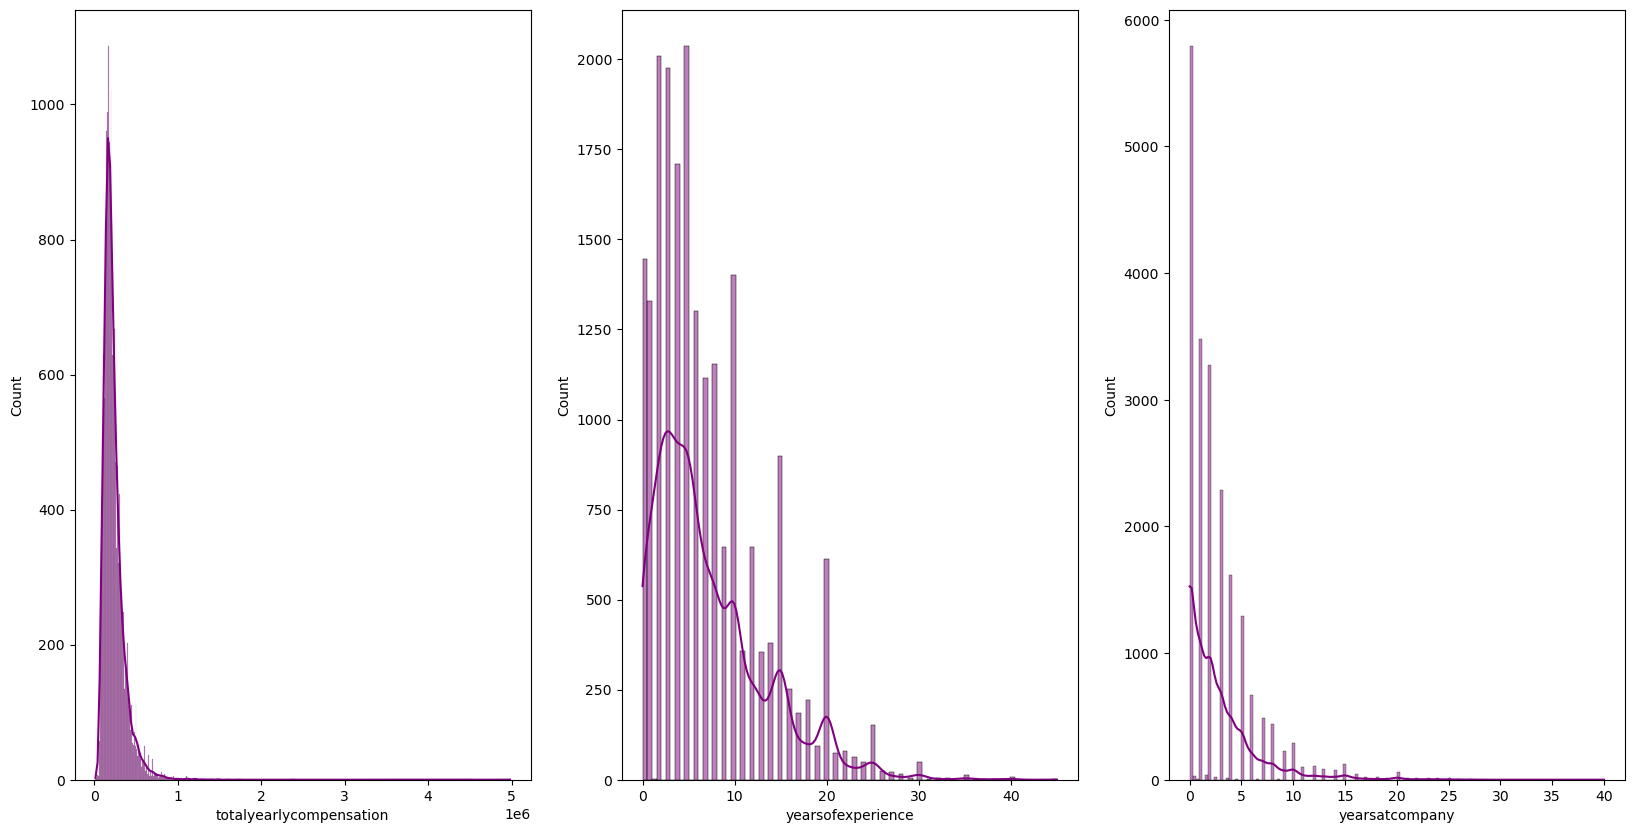

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
sns.set_palette('pastel')

for i, col in enumerate(df_num):
    sns.histplot(data=df_num, x=col, color="purple", kde=True, ax=axs[i%3] )
plt.show()

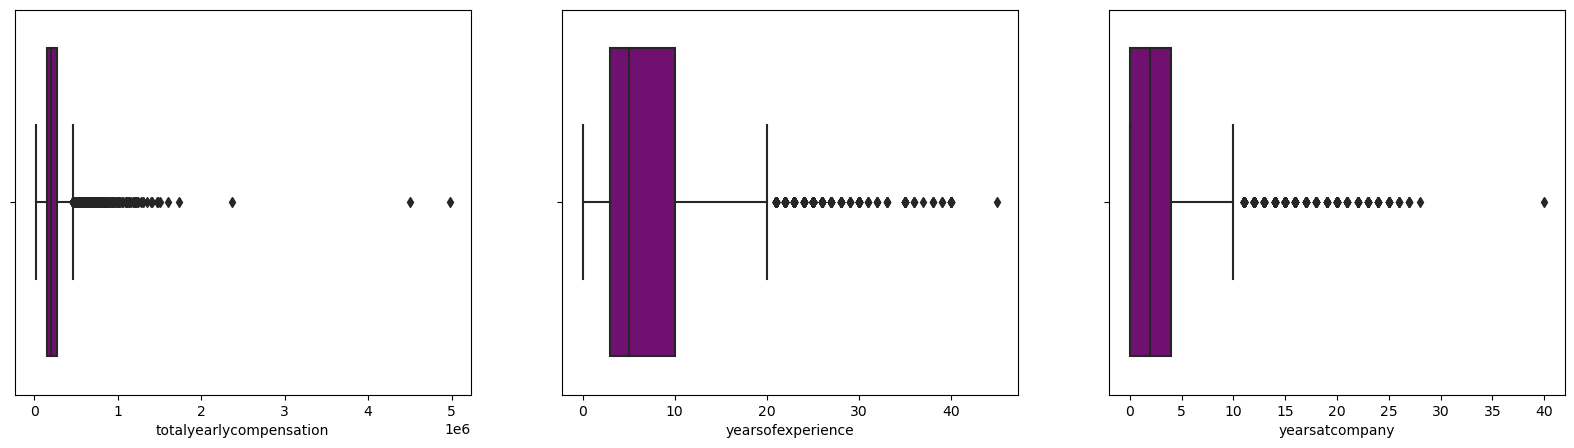

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
sns.set_palette('pastel')

for i, col in enumerate(df_num):
    sns.boxplot(data=df_num, x=col, color="purple", ax=axs[i%3] )
plt.show()

In [25]:
# remove outliers for target value
def remove_outliers(df, cols):
    for col in cols:
        q = st.quantiles(df[col], n=4)
        iqr = q[2] - q[0]
        mask = ~(((q[0] - 1.5*iqr) >= df[col]) | (df[col] >= (q[2] + 1.5*iqr)))
        df = df.loc[mask]
    return df

In [26]:
df = remove_outliers(df, ['totalyearlycompensation'])

In [27]:
#df = remove_outliers(df, ['totalyearlycompensation', 'yearsofexperience', 'yearsatcompany'])

In [28]:
df = df.reset_index(drop=True)

In [29]:
df.describe()

,totalyearlycompensation,yearsofexperience,yearsatcompany
count,19648.00,19648.00,19648.00
mean,209960.96,6.78,2.67
std,84848.95,5.73,3.32
min,15000.00,0.00,0.00
25%,150000.00,3.00,0.00
50%,195000.00,5.00,2.00
75%,259000.00,10.00,4.00
max,462000.00,45.00,40.00


In [30]:
pd.options.display.float_format = '{:.2f}'.format
df_num = df.select_dtypes(include=np.number)
df_num.describe()

,totalyearlycompensation,yearsofexperience,yearsatcompany
count,19648.00,19648.00,19648.00
mean,209960.96,6.78,2.67
std,84848.95,5.73,3.32
min,15000.00,0.00,0.00
25%,150000.00,3.00,0.00
50%,195000.00,5.00,2.00
75%,259000.00,10.00,4.00
max,462000.00,45.00,40.00


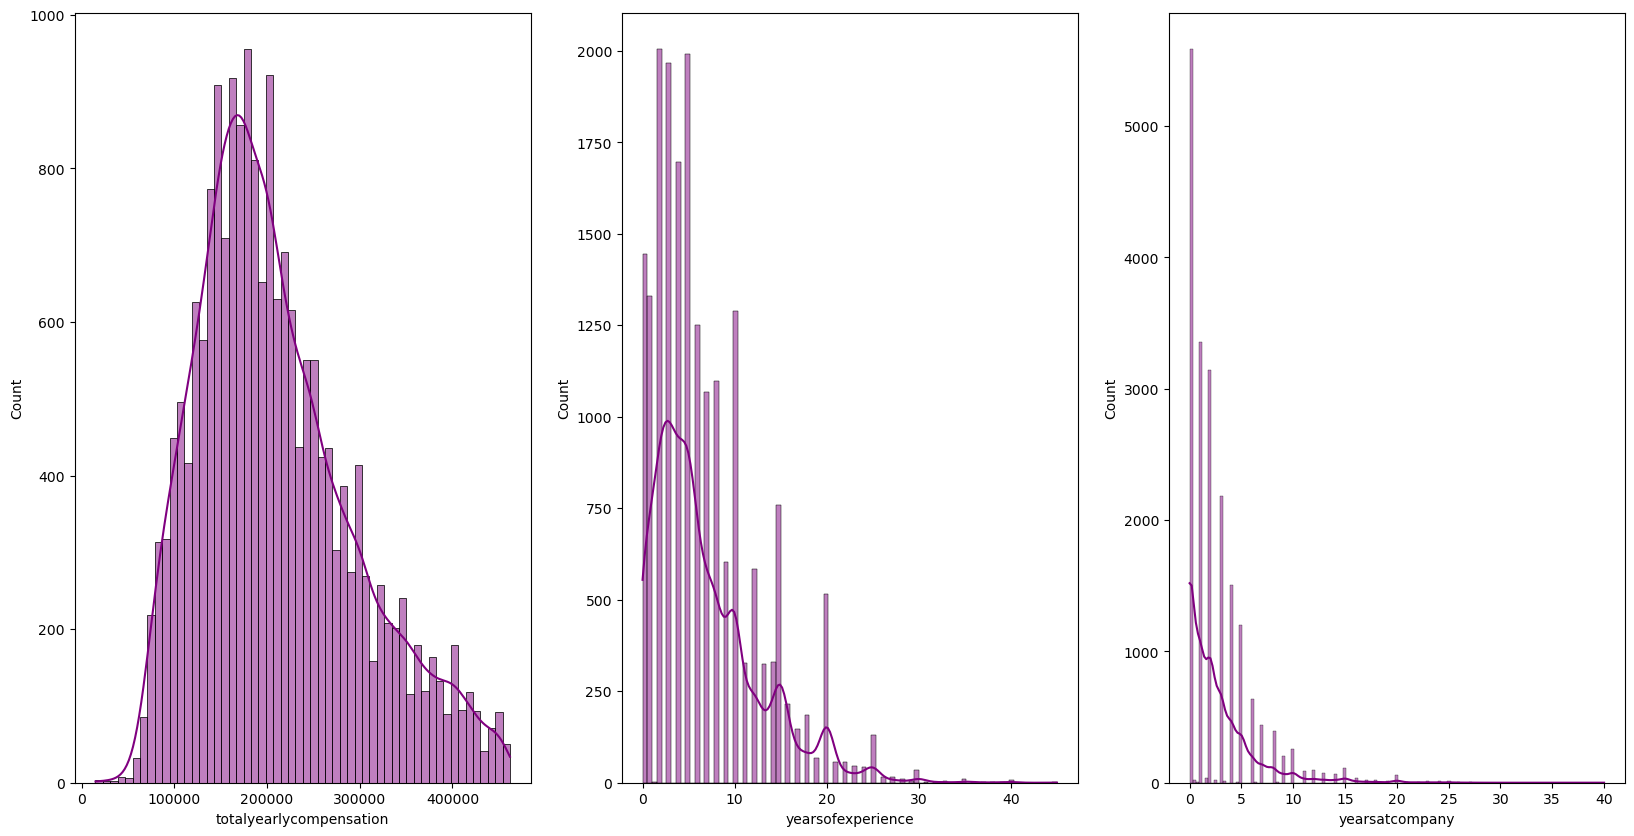

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
sns.set_palette('pastel')

for i, col in enumerate(df_num):
    sns.histplot(data=df_num, x=col, color="purple", kde=True, ax=axs[i%3] )
plt.show()

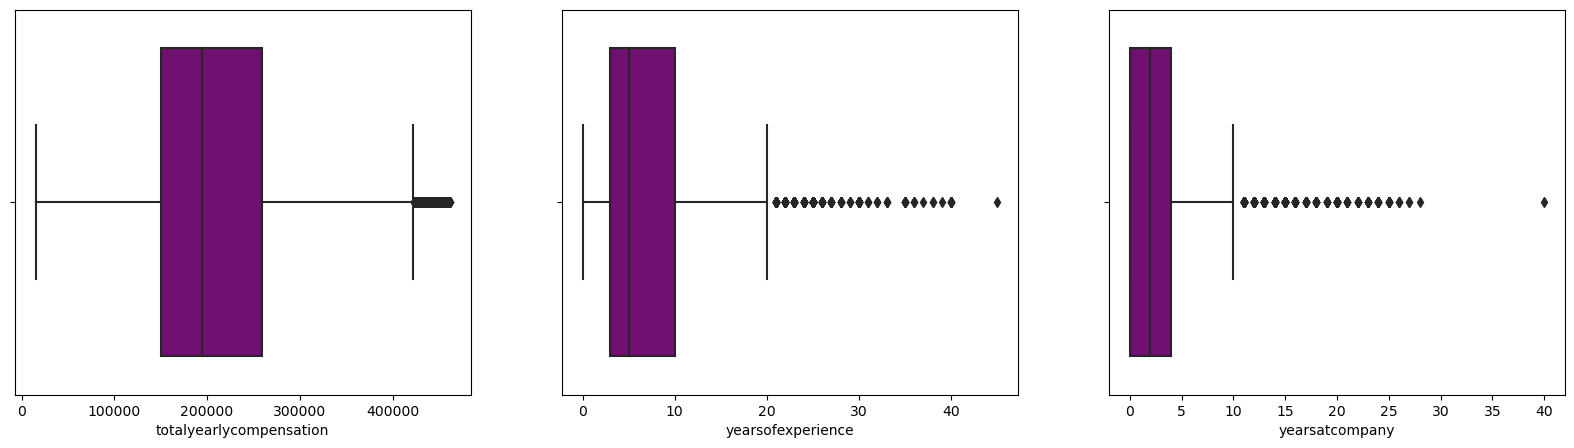

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
sns.set_palette('pastel')

for i, col in enumerate(df_num):
    sns.boxplot(data=df_num, x=col, color="purple", ax=axs[i%3] )
plt.show()

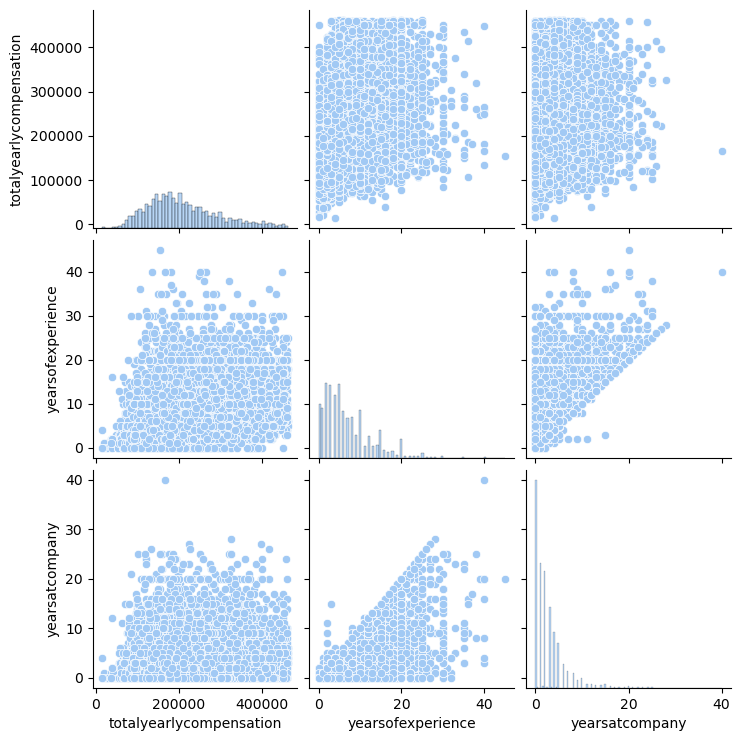

In [33]:
sns.pairplot(df)

/var/folders/mh/t2vz9kkn6z99y7p0rnwcq33m0000gn/T/ipykernel_18177/3225035937.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


<AxesSubplot:>

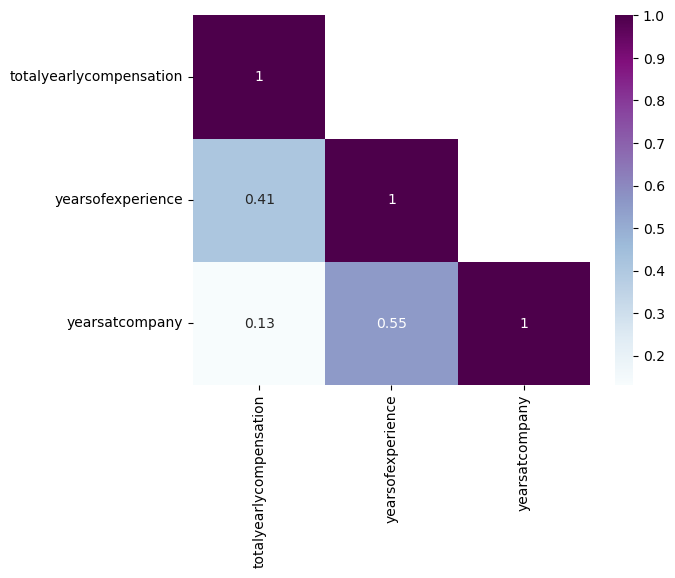

In [34]:
correlation_matrix = df.corr()
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices(len(correlation_matrix), k=1)]= True
sns.heatmap(correlation_matrix, cmap="BuPu", annot=True, mask=mask)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19648 entries, 0 to 19647
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company                  19648 non-null  object 
 1   title                    19648 non-null  object 
 2   totalyearlycompensation  19648 non-null  int64  
 3   location                 19648 non-null  object 
 4   yearsofexperience        19648 non-null  float64
 5   yearsatcompany           19648 non-null  float64
 6   gender                   19648 non-null  object 
 7   education                19648 non-null  object 
 8   country                  19648 non-null  object 
 9   state                    19648 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 1.5+ MB


In [36]:
df_for_eda = df
df_for_eda.to_csv('df_for_eda.csv', index=False)

### Preparation for modelling

In [37]:
#new gender column is_female
def gender(val):
    if val == "Female":
        return 1
    else:
        return 0

In [38]:
#create the is_female column
df["is_female"] = df['gender'].apply(gender)
df['is_female'].value_counts()

0    15996
1     3652
Name: is_female, dtype: int64

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19648 entries, 0 to 19647
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company                  19648 non-null  object 
 1   title                    19648 non-null  object 
 2   totalyearlycompensation  19648 non-null  int64  
 3   location                 19648 non-null  object 
 4   yearsofexperience        19648 non-null  float64
 5   yearsatcompany           19648 non-null  float64
 6   gender                   19648 non-null  object 
 7   education                19648 non-null  object 
 8   country                  19648 non-null  object 
 9   state                    19648 non-null  object 
 10  is_female                19648 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 1.6+ MB


In [40]:
#transform company comumn into is_faang? assuming they might be paid more
def faanging(val):
    if val == 'amazon' or val == 'facebook' or val == 'apple' or val == 'netflix' or val == 'google':
        return 1
    else:
        return 0

In [41]:
#create new column is FAANG? (assuming FAANG might pay more than other companies)
df['is_faang'] = df['company'].apply(faanging)
df["is_faang"].value_counts()

0    14241
1     5407
Name: is_faang, dtype: int64

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19648 entries, 0 to 19647
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company                  19648 non-null  object 
 1   title                    19648 non-null  object 
 2   totalyearlycompensation  19648 non-null  int64  
 3   location                 19648 non-null  object 
 4   yearsofexperience        19648 non-null  float64
 5   yearsatcompany           19648 non-null  float64
 6   gender                   19648 non-null  object 
 7   education                19648 non-null  object 
 8   country                  19648 non-null  object 
 9   state                    19648 non-null  object 
 10  is_female                19648 non-null  int64  
 11  is_faang                 19648 non-null  int64  
dtypes: float64(2), int64(3), object(7)
memory usage: 1.8+ MB


In [43]:
#ordinal encoder of the education column
array_cat_ord = df["education"].values
array_cat_ord =array_cat_ord.reshape(-1,1)
array_cat_ord.shape

(19648, 1)

In [44]:
encoder = OrdinalEncoder(categories=[["Highschool", 'Some College', 'Bachelor\'s Degree', 'Master\'s Degree', "PhD"]])
encoder.fit(array_cat_ord)
encoded_array = encoder.transform(array_cat_ord)

In [45]:
cat_ord_encoded = pd.DataFrame(encoded_array, columns=['education_enc'])



In [46]:
df['education_enc'] = cat_ord_encoded['education_enc']

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19648 entries, 0 to 19647
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company                  19648 non-null  object 
 1   title                    19648 non-null  object 
 2   totalyearlycompensation  19648 non-null  int64  
 3   location                 19648 non-null  object 
 4   yearsofexperience        19648 non-null  float64
 5   yearsatcompany           19648 non-null  float64
 6   gender                   19648 non-null  object 
 7   education                19648 non-null  object 
 8   country                  19648 non-null  object 
 9   state                    19648 non-null  object 
 10  is_female                19648 non-null  int64  
 11  is_faang                 19648 non-null  int64  
 12  education_enc            19648 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 1.9+ MB


In [48]:
#dummies for title
df["title"].value_counts(dropna=False)

Software Engineer               13064
Product Manager                  1582
Data Scientist                   1002
Hardware Engineer                 935
Software Engineering Manager      813
Technical Program Manager         642
Product Designer                  609
Business Analyst                  392
Solution Architect                352
Mechanical Engineer               257
Name: title, dtype: int64

In [49]:
df_title_to_dum = df["title"]

In [50]:
df_title_to_dum = df["title"]
df_title_dum = pd.get_dummies(df_title_to_dum, drop_first = True)
df_title_dum


,Data Scientist,Hardware Engineer,Mechanical Engineer,Product Designer,Product Manager,Software Engineer,Software Engineering Manager,Solution Architect,Technical Program Manager
0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
19643,0,0,0,0,0,1,0,0,0
19644,0,0,0,0,0,1,0,0,0
19645,0,0,0,0,0,1,0,0,0
19646,0,0,0,0,1,0,0,0,0


In [51]:
df =pd.concat([df, df_title_dum], axis=1 )


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19648 entries, 0 to 19647
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   company                       19648 non-null  object 
 1   title                         19648 non-null  object 
 2   totalyearlycompensation       19648 non-null  int64  
 3   location                      19648 non-null  object 
 4   yearsofexperience             19648 non-null  float64
 5   yearsatcompany                19648 non-null  float64
 6   gender                        19648 non-null  object 
 7   education                     19648 non-null  object 
 8   country                       19648 non-null  object 
 9   state                         19648 non-null  object 
 10  is_female                     19648 non-null  int64  
 11  is_faang                      19648 non-null  int64  
 12  education_enc                 19648 non-null  float64
 13  D

We ran the first model with and without transformation and then decided to add location as well.

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19648 entries, 0 to 19647
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   company                       19648 non-null  object 
 1   title                         19648 non-null  object 
 2   totalyearlycompensation       19648 non-null  int64  
 3   location                      19648 non-null  object 
 4   yearsofexperience             19648 non-null  float64
 5   yearsatcompany                19648 non-null  float64
 6   gender                        19648 non-null  object 
 7   education                     19648 non-null  object 
 8   country                       19648 non-null  object 
 9   state                         19648 non-null  object 
 10  is_female                     19648 non-null  int64  
 11  is_faang                      19648 non-null  int64  
 12  education_enc                 19648 non-null  float64
 13  D

In [54]:
#let's dummifying the states
df_state_to_dum = df["state"]
df_state_dum = pd.get_dummies(df_state_to_dum, drop_first = True)
df_state_dum.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19648 entries, 0 to 19647
Data columns (total 48 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   AR      19648 non-null  uint8
 1   AZ      19648 non-null  uint8
 2   CA      19648 non-null  uint8
 3   CO      19648 non-null  uint8
 4   CT      19648 non-null  uint8
 5   DC      19648 non-null  uint8
 6   DE      19648 non-null  uint8
 7   FL      19648 non-null  uint8
 8   GA      19648 non-null  uint8
 9   HI      19648 non-null  uint8
 10  IA      19648 non-null  uint8
 11  ID      19648 non-null  uint8
 12  IL      19648 non-null  uint8
 13  IN      19648 non-null  uint8
 14  KS      19648 non-null  uint8
 15  KY      19648 non-null  uint8
 16  LA      19648 non-null  uint8
 17  MA      19648 non-null  uint8
 18  MD      19648 non-null  uint8
 19  ME      19648 non-null  uint8
 20  MI      19648 non-null  uint8
 21  MN      19648 non-null  uint8
 22  MO      19648 non-null  uint8
 23  MS      196

In [55]:
df = pd.concat([df, df_state_dum], axis=1)


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19648 entries, 0 to 19647
Data columns (total 70 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   company                       19648 non-null  object 
 1   title                         19648 non-null  object 
 2   totalyearlycompensation       19648 non-null  int64  
 3   location                      19648 non-null  object 
 4   yearsofexperience             19648 non-null  float64
 5   yearsatcompany                19648 non-null  float64
 6   gender                        19648 non-null  object 
 7   education                     19648 non-null  object 
 8   country                       19648 non-null  object 
 9   state                         19648 non-null  object 
 10  is_female                     19648 non-null  int64  
 11  is_faang                      19648 non-null  int64  
 12  education_enc                 19648 non-null  float64
 13  D

In [57]:
#numerical df for modelling
df_num = df.select_dtypes(include = np.number)
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19648 entries, 0 to 19647
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   totalyearlycompensation       19648 non-null  int64  
 1   yearsofexperience             19648 non-null  float64
 2   yearsatcompany                19648 non-null  float64
 3   is_female                     19648 non-null  int64  
 4   is_faang                      19648 non-null  int64  
 5   education_enc                 19648 non-null  float64
 6   Data Scientist                19648 non-null  uint8  
 7   Hardware Engineer             19648 non-null  uint8  
 8   Mechanical Engineer           19648 non-null  uint8  
 9   Product Designer              19648 non-null  uint8  
 10  Product Manager               19648 non-null  uint8  
 11  Software Engineer             19648 non-null  uint8  
 12  Software Engineering Manager  19648 non-null  uint8  
 13  S

In [58]:
#df_model_two_.to_csv('df_model_two_.csv', index=False)

After running the model again with location, we find that only some states seem to have a significative impact.

In [59]:
#let's keep only the states that seem to have an actual impact (CA, MA, NY, WA)
keep_cols = list(range(15)) + [17, 32, 47, 59]

df_model_three = df_num.iloc[:, keep_cols]

In [60]:
df_model_three.to_csv('df_model_three_noout.csv', index=False)

### Modelling

In [61]:
df = pd.read_csv('df_model_three_noout.csv')
df

,totalyearlycompensation,yearsofexperience,yearsatcompany,is_female,is_faang,education_enc,Data Scientist,Hardware Engineer,Mechanical Engineer,Product Designer,Product Manager,Software Engineer,Software Engineering Manager,Solution Architect,Technical Program Manager,CA,MA,NY,WA
0,125000,1.00,0.00,0,0,4.00,1,0,0,0,0,0,0,0,0,0,0,0,0
1,170000,0.00,0.00,0,0,3.00,0,0,0,0,0,1,0,0,0,0,0,1,0
2,332000,1.00,0.00,0,1,4.00,1,0,0,0,0,0,0,0,0,1,0,0,0
3,240000,3.00,3.00,1,1,4.00,0,0,0,0,0,1,0,0,0,1,0,0,0
4,310000,25.00,9.00,0,0,4.00,0,0,0,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19643,127000,2.00,0.00,0,0,2.00,0,0,0,0,0,1,0,0,0,0,0,0,0
19644,92000,2.00,2.00,0,0,2.00,0,0,0,0,0,1,0,0,0,0,0,0,0
19645,95000,3.00,3.00,0,0,2.00,0,0,0,0,0,1,0,0,0,0,0,0,0
19646,241000,9.00,0.00,1,1,2.00,0,0,0,0,1,0,0,0,0,0,0,0,1


In [62]:
df.describe()

,totalyearlycompensation,yearsofexperience,yearsatcompany,is_female,is_faang,education_enc,Data Scientist,Hardware Engineer,Mechanical Engineer,Product Designer,Product Manager,Software Engineer,Software Engineering Manager,Solution Architect,Technical Program Manager,CA,MA,NY,WA
count,19648.00,19648.00,19648.00,19648.00,19648.00,19648.00,19648.00,19648.00,19648.00,19648.00,19648.00,19648.00,19648.00,19648.00,19648.00,19648.00,19648.00,19648.00,19648.00
mean,209960.96,6.78,2.67,0.19,0.28,2.61,0.05,0.05,0.01,0.03,0.08,0.66,0.04,0.02,0.03,0.40,0.04,0.09,0.22
std,84848.95,5.73,3.32,0.39,0.45,0.65,0.22,0.21,0.11,0.17,0.27,0.47,0.20,0.13,0.18,0.49,0.19,0.29,0.41
min,15000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,150000.00,3.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,195000.00,5.00,2.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,259000.00,10.00,4.00,0.00,1.00,3.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
max,462000.00,45.00,40.00,1.00,1.00,4.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


<AxesSubplot:xlabel='totalyearlycompensation', ylabel='Count'>

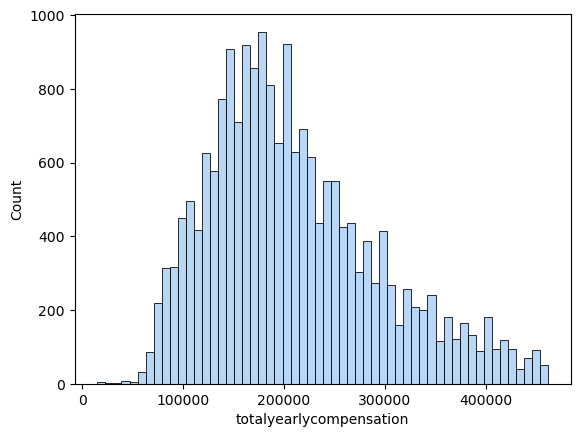

In [63]:
sns.histplot(df, x='totalyearlycompensation')

In [64]:
#log the target variable
df['totalyearlycompensation'] = np.log(df['totalyearlycompensation'])

<AxesSubplot:xlabel='totalyearlycompensation', ylabel='Count'>

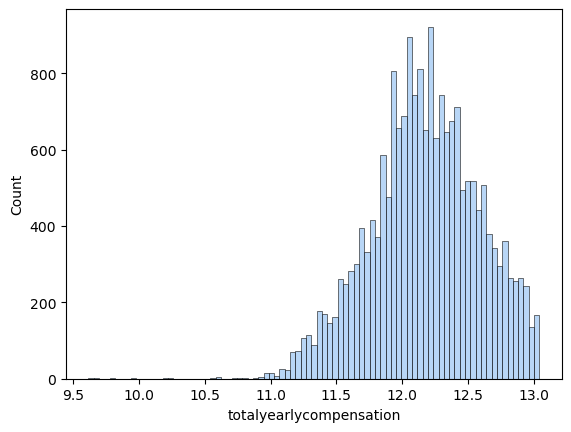

In [65]:
sns.histplot(df, x='totalyearlycompensation')

In [66]:
##X-Y split
X = df.drop('totalyearlycompensation', axis = 1)
y = df['totalyearlycompensation']

In [67]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [68]:
#OLS - 
X_train_const = sm.add_constant(X_train.to_numpy()) #add a constant

model = sm.OLS(y_train, X_train_const).fit()
predictions_train = model.predict(X_train_const)

X_test_const = sm.add_constant(X_test.to_numpy()) #add a constant
predictions_test = model.predict(X_test_const)

print_model = model.summary()
print(print_model)

                               OLS Regression Results                              
Dep. Variable:     totalyearlycompensation   R-squared:                       0.490
Model:                                 OLS   Adj. R-squared:                  0.489
Method:                      Least Squares   F-statistic:                     733.5
Date:                     Fri, 21 Apr 2023   Prob (F-statistic):               0.00
Time:                             10:41:52   Log-Likelihood:                -2697.2
No. Observations:                    13753   AIC:                             5432.
Df Residuals:                        13734   BIC:                             5576.
Df Model:                               18                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

In [69]:
percent = (math.exp( -0.0386)-1)*100
percent

-3.7864513619658258

In [70]:
y_test = pd.DataFrame(y_test)
y_test = y_test.reset_index(drop=True)
y_test

,totalyearlycompensation
0,12.13
1,12.03
2,12.36
3,11.91
4,12.71
...,...
5890,11.64
5891,12.14
5892,12.07
5893,12.43


In [71]:
y_pred = pd.DataFrame(predictions_test)
y_pred

,0
0,12.63
1,12.01
2,12.28
3,12.02
4,12.37
...,...
5890,12.02
5891,12.56
5892,12.23
5893,12.25


In [72]:
result=pd.DataFrame({"y_test": y_test["totalyearlycompensation"],"y_pred": y_pred[0]})
result

,y_test,y_pred
0,12.13,12.63
1,12.03,12.01
2,12.36,12.28
3,11.91,12.02
4,12.71,12.37
...,...,...
5890,11.64,12.02
5891,12.14,12.56
5892,12.07,12.23
5893,12.43,12.25


In [73]:
result["residuals"] = result["y_test"] - result["y_pred"]

<AxesSubplot:xlabel='y_pred', ylabel='y_test'>

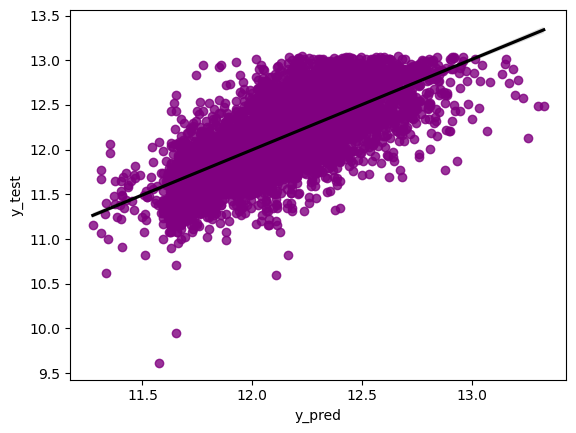

In [74]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A straight line
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "purple"}, line_kws={"color": "black"})

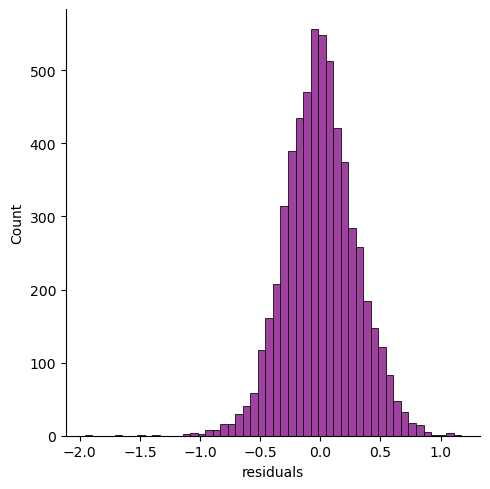

In [75]:
# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
sns.displot(result["residuals"], bins=50, color="purple", kde=False)

<AxesSubplot:xlabel='y_pred', ylabel='residuals'>

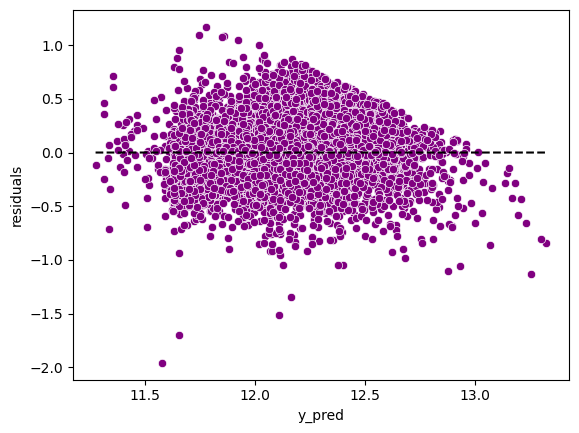

In [76]:
sns.scatterplot(x="y_pred", y="residuals", color="purple", data=result)
sns.lineplot(x=result["y_pred"], y=np.zeros(len(result)), color= "black", linestyle='dashed')